# RSI (Relative Strength Index) Strategy

In [1]:
import logging, os, pickle
import requests, glob
from datetime import datetime
import pandas as pd
import time
from datetime import date
import json, re, sys, h5py
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import shutil
from matplotlib.pyplot import cm
import numpy as np
import scipy.stats as stats
from scipy import stats
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
import sys
import seaborn as sns
sys.path.append('C:\\Users\Bae Kyungmo\OneDrive\Desktop\StockTraidingAutomation\DataModeling')
from Loader_v2 import Loader
ldr = Loader(pwd='')

### 1) Classical RSI approach
* Up : price goes up
* Down : price goes down
* RS = MA(Up,ndays) / MA(Down,ndays)
* RSI = RS / (1+RS) * 100
* If RSI <= 30 buy, else RSI >= 70 sell.
* Of course this (30,70) can be adjusted like (20,80) or (10, 90) and so on.

In [2]:
def MDD(pr):
    code = pr.columns[0]
    x = pr[code]
    """
    MDD(Maximum Draw-Down)
    :return: (peak_upper, peak_lower, mdd rate)
    """
    arr_v = np.array(x)
    peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
    peak_upper = np.argmax(arr_v[:peak_lower])
    return round((arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper],2)

In [3]:
def SharpeRatio(rt_df, bncmrk=0.02):
    SR = np.sqrt(len(rt_df))*(rt_df['return'].mean() - bncmrk) / rt_df['return'].std()
    return SR

In [4]:
def SMA(pr, ndays=22, min_days=1):
    code = pr.columns[0]
    return pr[[code]].rolling(window=ndays, min_periods=min_days).mean()

In [5]:
def EMA(pr, ndays=22, min_days=1):
    code = pr.columns[0]
    return pr[[code]].ewm(ndays,min_periods=min_days).mean()

In [26]:
def RSI(pr_df, ndays=14):
    pr = pr_df.copy()
    code = pr.columns[0]
    delta = pr[code].diff(1)
    delta.fillna(0,inplace=True)
    
    Up = delta.copy()
    Down = delta.copy()
    Up[Up<0] = 0
    Down[Down>0] = 0
    pr['Up'] = Up
    pr['Down'] = Down
    avgGain = SMA(pr[['Up']], ndays)['Up']
    avgLoss = abs(SMA(pr[['Down']], ndays))['Down']
    RS = avgGain / avgLoss
    RSI = 100.0 - (100.0 / (1.0 + RS))
    pr['RSI'] = RSI
    return pr

In [60]:
def RSI_Signal(dff, buyRSI=30, sellRSI=70):
    df = dff.copy()
    df.columns = ['close','RSI']
    Buy=[]
    Sell=[]
    Buy.append(np.nan)
    Sell.append(np.nan)
    flag = -1
    for i in range(1, len(df)):
        if df['RSI'][i] <= buyRSI and flag != 1:
            Buy.append(df['close'][i])
            Sell.append(np.nan)
            flag = 1
        elif df['RSI'][i] >= sellRSI and flag != 0:
            Sell.append(df['close'][i])
            Buy.append(np.nan)
            flag = 0
        else :
            Buy.append(np.nan)
            Sell.append(np.nan)
    df['BuySignal'] = Buy
    df['SellSignal'] = Sell
    
    """
    For the first position being long, if SellSignal is prior to BuySignal
    remove that position..
    """
    firstSell = df[df['SellSignal'].notnull()].index[0]
    firstBuy = df[df['BuySignal'].notnull()].index[0]
    if firstBuy > firstSell : 
        df.loc[firstSell,'SellSignal'] = np.nan
    return df

In [48]:
def BackTest(obv):
    tmp = obv[(~obv['BuySignal'].isnull())|(~obv['SellSignal'].isnull())]
    tmp['BuySignal'] = tmp['BuySignal'].fillna(0)
    tmp['SellSignal'] = tmp['SellSignal'].fillna(0)
    tmp['series'] = tmp['BuySignal'] + tmp['SellSignal']
    tmp['return'] = tmp['series'].pct_change()+1
    tmp2 = tmp[tmp.SellSignal!=0.0]
    cm_rt = tmp2['return'].cumprod()[-1]
    hit_ratio = round(len(tmp2[tmp2['return']>=1]) / len(tmp2),2)
    best_rt = tmp2['return'].max()-1
    worst_rt = tmp2['return'].min()-1
    ar_mean = tmp2['return'].mean()
    gr_mean = np.exp(np.log(cm_rt)/len(tmp2))
    mdd = MDD(obv[['close']])
    SR = SharpeRatio(tmp2[['return']]-1)
    test_rst = pd.DataFrame(columns=['CumulativeReturn','HitRatio','BestReturn','WorstReturn','MDD','SimpleMean','GeoMean','#Trade'])
    test_rst.loc[0,'CumulativeReturn'] = round(cm_rt,2)
    test_rst.loc[0,'HitRatio'] = hit_ratio
    test_rst.loc[0,'BestReturn'] = round(best_rt,2)
    test_rst.loc[0,'WorstReturn'] = round(worst_rt,2)
    test_rst.loc[0,'SimpleMean'] = round(ar_mean,2)
    test_rst.loc[0,'GeoMean'] = round(gr_mean,2)
    test_rst.loc[0,'MDD'] = round(mdd*(-1),2)
    test_rst.loc[0,'SharpeRatio'] = round(SR,2)
    test_rst.loc[0,'#Trade'] = round(len(tmp2),2)
    return tmp2, test_rst

In [49]:
def RSI_Run(start, end, code, ndays=14, buyRSI=30, sellRSI=70, doplot=True):
    pr = ldr.GetPricelv2(start, end, [code])
    rsi = RSI(pr, ndays=ndays)
    if doplot :
        plt.style.use('fivethirtyeight')
        rsi[['RSI']].plot(figsize=(8,6))
        plt.title("RSI indicator for {}".format(code))
    rsi_sig = RSI_Signal(rsi[[code,'RSI']], buyRSI=buyRSI, sellRSI=sellRSI)
    if doplot :
        plt.figure(figsize=(8,6))
        plt.scatter(rsi_sig.index, rsi_sig['BuySignal'], color='green',label='BuySignal',marker='^',alpha=1)
        plt.scatter(rsi_sig.index, rsi_sig['SellSignal'], color='red',label='SellSignal',marker='v',alpha=1)
        plt.plot(rsi_sig['close'], label='Close Price', alpha=0.35)
        plt.xticks([],rotation=45)
        plt.title('RSI on {} during {} ~ {}'.format(code,start,end))
        plt.xlabel('Date',fontsize=15)
        plt.ylabel('Close Price KRW',fontsize=15)
        plt.legend(loc='upper left')
        plt.show()
    _, rst = BackTest(rsi_sig)
    rst.index = [code]
    return rst

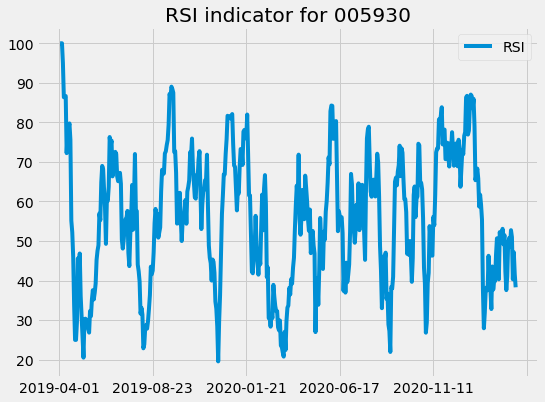

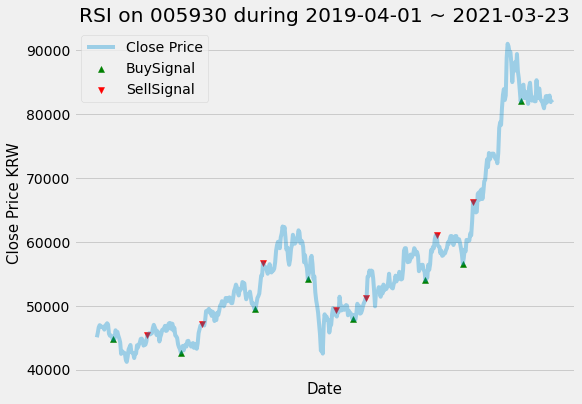

Wall time: 754 ms


,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.65,0.86,0.17,-0.09,0.32,1.08,1.07,7,1.68


In [73]:
%%time
RSI_Run('2019-04-01','2021-03-23','005930',14,30,70,True)

In [74]:
%%time
total = pd.DataFrame()
start = '2019-04-01'
end = '2021-03-23'
for cd in ['005930','005935','034220','066570']:
    total = pd.concat([total,RSI_Run(start, end, cd,14,30,70,False)])

Wall time: 709 ms


In [75]:
total

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.65,0.86,0.17,-0.09,0.32,1.08,1.07,7,1.68
005935,1.16,0.8,0.1,-0.07,0.33,1.03,1.03,5,0.38
034220,0.82,0.4,0.2,-0.23,0.6,0.98,0.96,5,-0.54
066570,0.75,0.5,0.08,-0.21,0.23,0.94,0.93,4,-1.17


### Conclusion
* HitRatio is better than any other indicators but other indexes are all bad...
* Thought of as unstable momentum catcher.
* I'm gonna try using EMA than SMA in inner logic's RSI calculation.

---

### 2) RSI using EMA
* The only difference is calculating RS using EMA not SMA.

In [76]:
def RSI_EMA(pr_df, ndays=14):
    pr = pr_df.copy()
    code = pr.columns[0]
    delta = pr[code].diff(1)
    delta.fillna(0,inplace=True)
    
    Up = delta.copy()
    Down = delta.copy()
    Up[Up<0] = 0
    Down[Down>0] = 0
    pr['Up'] = Up
    pr['Down'] = Down
    avgGain = EMA(pr[['Up']], ndays)['Up']
    avgLoss = abs(EMA(pr[['Down']], ndays))['Down']
    RS = avgGain / avgLoss
    RSI = 100.0 - (100.0 / (1.0 + RS))
    pr['RSI'] = RSI
    return pr

In [78]:
def RSI_Run_v2(start, end, code, ndays=14, buyRSI=30, sellRSI=70, doplot=True):
    pr = ldr.GetPricelv2(start, end, [code])
    rsi = RSI_EMA(pr, ndays=ndays)
    if doplot :
        plt.style.use('fivethirtyeight')
        rsi[['RSI']].plot(figsize=(8,6))
        plt.title("RSI indicator for {}".format(code))
    rsi_sig = RSI_Signal(rsi[[code,'RSI']], buyRSI=buyRSI, sellRSI=sellRSI)
    if doplot :
        plt.figure(figsize=(8,6))
        plt.scatter(rsi_sig.index, rsi_sig['BuySignal'], color='green',label='BuySignal',marker='^',alpha=1)
        plt.scatter(rsi_sig.index, rsi_sig['SellSignal'], color='red',label='SellSignal',marker='v',alpha=1)
        plt.plot(rsi_sig['close'], label='Close Price', alpha=0.35)
        plt.xticks([],rotation=45)
        plt.title('RSI on {} during {} ~ {}'.format(code,start,end))
        plt.xlabel('Date',fontsize=15)
        plt.ylabel('Close Price KRW',fontsize=15)
        plt.legend(loc='upper left')
        plt.show()
    _, rst = BackTest(rsi_sig)
    rst.index = [code]
    return rst

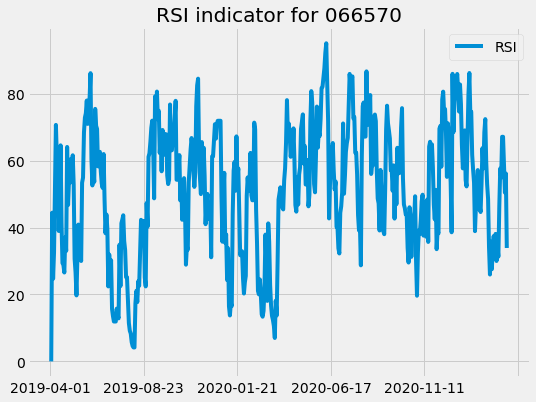

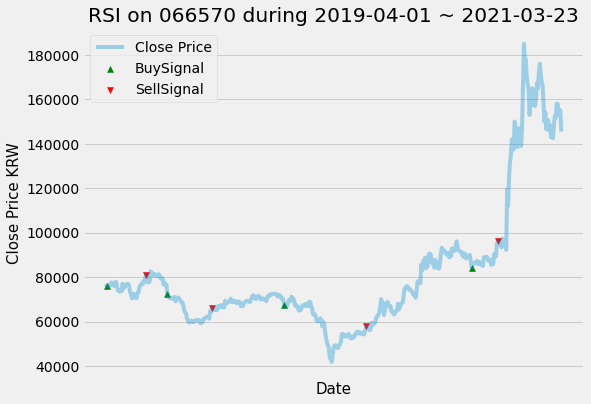

Wall time: 766 ms


,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
066570,0.96,0.5,0.15,-0.14,0.23,1,0.99,4,-0.35


In [90]:
%%time
RSI_Run_v2('2019-04-01','2021-03-23','066570',5,20,80,True)

In [91]:
%%time
total2 = pd.DataFrame()
start = '2019-04-01'
end = '2021-03-23'
for cd in ['005930','005935','034220','066570']:
    total2 = pd.concat([total2,RSI_Run_v2(start, end, cd,5,20,80,False)])

Wall time: 673 ms


In [92]:
total2

,CumulativeReturn,HitRatio,BestReturn,WorstReturn,MDD,SimpleMean,GeoMean,#Trade,SharpeRatio
005930,1.42,1,0.13,0.01,0.32,1.07,1.07,5,2.35
005935,1.43,1,0.14,0.01,0.33,1.09,1.09,4,2.69
034220,0.74,0.33,0.24,-0.28,0.6,0.93,0.9,3,-0.57
066570,0.96,0.5,0.15,-0.14,0.23,1,0.99,4,-0.35


### Conclusion
* Worse..
* I think the 'relative' thing should be calculated as equally accumulated RS.
* Since at some points Up/Down would increase/decrease and the idea is not weighting recent RS more but checking some accumulated RS in a period where those values reach the top/bottom.